# Определение перспективного тарифа для телеком компании

Предоставлены данные - выборка из 500 абонентов оператора Мегалайн. Часть из них пользуется тарифом Smart, другая часть - тарифом Ultra. 
Необходимо проанализировать поведение клиентов и понять, какой тариф лучше

### Table of contents
1. [Импорт данных и инфо о таблицах](#first)
    1. [Вывод](#conc1)
2. [Подготовка и обработка данных](#second)
    1. [Вывод](#conc2)
3. [Анализ данных](#third)
    1. [Вывод](#conc3)
4. [Проверка гипотез](#forth)
5. [Общий вывод](#conc)

### Шаг 1: Откройте файл с данными и изучите общую информацию <a name="first"></a>

In [18]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

In [19]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [20]:
for item in [calls, internet, messages, users]:
    item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
<class 'pandas.core.frame.DataFrame'>
Rang

In [21]:
display(calls.sample(3))
display(internet.sample(3))
display(messages.sample(3))
display(users.sample(3))
display(tariffs)

,id,call_date,duration,user_id
5547,1015_267,2018-12-04,4.47,1015
819,1003_112,2018-10-09,0.53,1003
88423,1222_161,2018-10-09,16.36,1222


,Unnamed: 0,id,mb_used,session_date,user_id
86446,86446,1292_562,144.13,2018-02-22,1292
88046,88046,1298_339,169.60,2018-10-07,1298
62516,62516,1212_9,636.66,2018-12-21,1212


,id,message_date,user_id
31474,1140_25,2018-12-31,1140
32007,1144_146,2018-08-09,1144
14073,1059_90,2018-06-06,1059


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
166,1166,48,NaN,Нижний Новгород,Святослав,Жданов,2018-08-17,ultra
231,1231,63,NaN,Чебоксары,Касьян,Авдюков,2018-05-23,ultra
14,1014,64,NaN,Чебоксары,Яков,Акинфьев,2018-05-15,smart


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Вывод <a name="conc1"></a>

В столбце churn_data есть пропущенные значения dataset "users". Во всех столбцах даты в неверном формате. Мегабайты и минуты указаны со знаками после запятой (оператор округляет эти показания вверх). Столбцы id в датасетах типа object, но это числа. 

### Шаг 2. Подготовьте данные <a name="second"></a>

Приведите данные к нужным типам;
Найдите и исправьте ошибки в данных.
Поясните, какие ошибки вы нашли и как их исправили. Обратите внимание, что длительность многих звонков — 0.0 минут. Это могут быть пропущенные звонки. Обрабатывать ли эти нулевые значения, решать вам — оцените, как их отсутствие повлияет на результаты анализа.
Посчитайте для каждого пользователя:
-количество сделанных звонков и израсходованных минут разговора по месяцам;
-количество отправленных сообщений по месяцам;
-объем израсходованного интернет-трафика по месяцам;
-помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [22]:
#приведем даты в столбцах к единому формату даты
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
#т.к. оператор округляет вверх до минуты и мегабайта все расходы, округлим в соответствующих столбцах минуты и мб.
calls['duration'] = calls['duration'].apply(np.ceil)
calls['duration'] = calls['duration'].astype('int')
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet['mb_used'] = internet['mb_used'].astype('int')
#удалим строки с 0, т.к. они не повлияют на данные, они говорят о том, что звонок или интернет-соединение не были выполнены.
internet['mb_used'] = internet['mb_used'].replace(0, np.NaN)
internet = internet.dropna()
calls['duration'] = calls['duration'].replace(0, np.NaN)
calls = calls.dropna()
#приведем столбцы id к числовой форме
calls['id'] = calls['id'].astype('int')
internet['id'] = internet['id'].astype('int')
messages['id'] = messages['id'].astype('int')

Здесь мы произвели всю необходимую предобработку данных: привели все значения к необходимым форматам, округлили минуты и мегабайты так, как обычно это делает оператор - до целого числа в большую сторону. 

In [23]:
#создадим столбец "месяц" в каждой таблице
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month
#т.к. в дальнейшем для измерения нам потребуются данные в гигабайтах - перевожу мб в гб (1 гб = 1024мб)
internet['gb_used'] = internet['mb_used'] / 1024
#создадим сводные таблицы с разбивкой по месяцам, сколько в месяц каждый абонент потратил минут
pivot_calls = calls.pivot_table(index=['month','user_id'], values='duration', aggfunc=('sum', 'count'))
pivot_messages = messages.pivot_table(index=['month', 'user_id'], values='message_date', aggfunc=('count'))
pivot_internet = internet.pivot_table(index=['month', 'user_id'], values = 'gb_used', aggfunc=('sum'))

Здесь уже приступаем к подготовке одной общей таблицы: Сначала создаем в каждой таблице столбец с месяцами, т.к. нам необходимо иметь все данные в разбивке по месяцам. После создаем столбец, где переводим мегабайты в гигабайты, тк. в тарифе считаются именно гб. 
После создаем сводные таблицы, где приводим данные к нужному нам виду; для каждого ИД с разбивкой по месяцам мы теперь знаем суммарное количество отправленных смс, использованных гб и потраченных минут.

In [24]:
#объединим таблицы в одну с данными по пользователям и использованным услугам. 
group_ci = pivot_calls.join(pivot_internet, on=['month', 'user_id'])
group_ci = group_ci.reset_index()
group_cmi = group_ci.join(pivot_messages, on=['month', 'user_id'])
group_cmi = group_cmi.reset_index()
group_all = group_cmi.merge(users,on='user_id')
group_all=group_all.fillna(0).sort_values(by='user_id')
del group_all['index']
#для удобства переименовываю некоторые столбцы в более понятные названия
group_all.rename(columns={'count': 'calls_num', 'sum': 'min_sum', 'message_date': 'sms_num'}, inplace=True)
group_all.head()

,month,user_id,calls_num,min_sum,gb_used,sms_num,age,churn_date,city,first_name,last_name,reg_date,tariff
1698,5,1000,17,159.0,2.203125,22.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1700,7,1000,41,340.0,13.687500,75.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1701,8,1000,42,408.0,13.740234,81.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1702,9,1000,46,466.0,14.239258,57.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1703,10,1000,44,350.0,14.372070,73.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


Теперь у меня есть единая таблица, в которой объединены данные по использованным минутам, смс и гигабайтам. Для каждого ид так же прописаны данные абонента и тариф, которым он пользуется. 

In [25]:
#построим функцию для расчета расходов на мобильную связь.
def tariff_cost(row):
    if row['tariff'] == 'smart':
        if row['sms_num'] > 50:
            sms_extra = (row['sms_num'] - 50)*3
        else:
            sms_extra = 0
        if row['min_sum'] > 500:
            min_extra = (row['min_sum'] - 500)*3
        else:
            min_extra = 0
        if row['gb_used'] > 15:
            gb_extra = (row['gb_used'] - 15)*200
        else:
            gb_extra = 0
        total_cost = sms_extra + min_extra + gb_extra + 550
    if row['tariff'] == 'ultra':
        if row['sms_num'] > 1000:
            sms_extra = (row['sms_num'] - 1000)*1
        else:
            sms_extra = 0
        if row['min_sum'] > 3000:
            min_extra = (row['min_sum'] - 3000)*1
        else:
            min_extra = 0
        if row['gb_used'] > 30:
            gb_extra = (row['gb_used'] - 30)*150
        else:
            gb_extra = 0
        total_cost = sms_extra + min_extra + gb_extra + 1950
    return total_cost

group_all['tariff_cost'] = group_all.apply(tariff_cost, axis=1) #создадим столбец, куда запишем функцию с оплатой за пользование услугами для каждой строки
group_all['tariff_cost'] = round(group_all['tariff_cost']) #для удобства я округляю все суммы в столбце
group_all['tariff_cost'] = group_all['tariff_cost'].astype('int') #приводим столбец к формату int
group_all

,month,user_id,calls_num,min_sum,gb_used,sms_num,age,churn_date,city,first_name,last_name,reg_date,tariff,tariff_cost
1698,5,1000,17,159.0,2.203125,22.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950
1700,7,1000,41,340.0,13.687500,75.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950
1701,8,1000,42,408.0,13.740234,81.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950
1702,9,1000,46,466.0,14.239258,57.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950
1703,10,1000,44,350.0,14.372070,73.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2542,9,1498,53,471.0,21.646484,44.0,68,2018-10-25 00:00:00,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,1879
2917,11,1499,62,612.0,17.562500,59.0,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,1426
2916,10,1499,44,449.0,17.391602,48.0,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,1028
2915,9,1499,8,70.0,1.804688,11.0,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,550


### Вывод <a name="conc2"></a>

Мы соединили все таблицы кроме тарифов в одну. Теперь у нас есть по каждому клиенту вся доступная информация плюс его абонентская плата по месяцам. Уже на данном этапе можно увидеть перерасходы по тарифу Смарт. 

### Шаг 3. Проанализируйте данные <a name="third"></a>

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

count    2221.000000
mean     1234.473210
std       788.603908
min       550.000000
25%       550.000000
50%       961.000000
75%      1671.000000
max      6711.000000
Name: tariff_cost, dtype: float64

621896.1241693741

Text(0, 0.5, 'Кол-во пользователей, чел.')

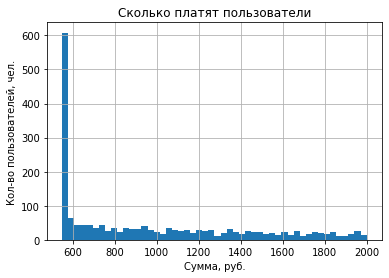

In [26]:
#создаем выборку только пользователей с тарифом Smart и смотрим по стоимости среднее, дисперсию, стандартное отклонение. Выводим диаграмму.
smart = group_all.query('tariff == "smart"')
display(smart['tariff_cost'].describe())
var_smart = np.var(smart['tariff_cost'], ddof=1)
display(var_smart)
smart['tariff_cost'].hist(bins=50, range=(550,2000))

# Add labels
plt.title('Сколько платят пользователи')
plt.xlabel('Сумма, руб.')
plt.ylabel('Кол-во пользователей, чел.')

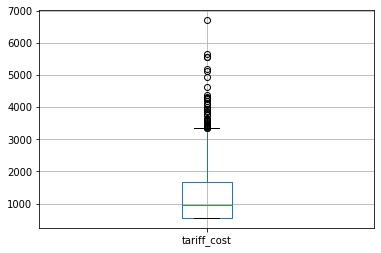

In [27]:
smart.boxplot(column='tariff_cost')

Среднее - 1234,47
Ст. отклонение - 788,60
Медиана - 961
Дисперсия - 621896,12.
На диаграмме видно, что около 600 человек платят 550 руб/мес, это самый высокий столбик диаграммы, соответственно какая-то часть людей не выходит за рамки тарифа. Но все же большинство выходят за рамки предоставленных услуг, это видно и по среднему и по медиане. В целом клиенты здесь не платят больше 2000 за месяц. 

count    2221.000000
mean       15.851038
std         5.745554
min         0.000000
25%        12.375000
50%        16.139648
75%        19.597656
max        37.705078
Name: gb_used, dtype: float64

33.01138891705983

Text(0, 0.5, 'Кол-во пользователей, чел.')

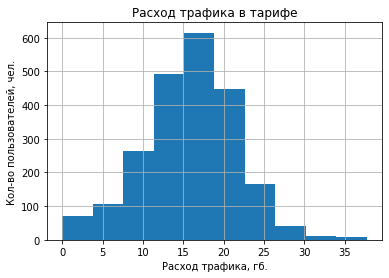

In [28]:
#Смотрим среднее, дисперсию и стандартное отклонение по использованному интернету среди пользователей Smart и выводим диаграмму. 
display(smart['gb_used'].describe())
var_smart_gb = np.var(smart['gb_used'], ddof=1)
display(var_smart_gb)
smart['gb_used'].hist(bins=10)
# Add labels
plt.title('Расход трафика в тарифе')
plt.xlabel('Расход трафика, гб.')
plt.ylabel('Кол-во пользователей, чел.')

Среднее - 15,85
Ст. отклонение - 5,75
Медиана - 16,14
Дисперсия - 33,01.
На диаграмме видно, что большинство значений лежит в промежутке от 15 до 20 гб. Соответственно здесь нормальное распределение с центром примерно на 16-18 гб. Соответственно по этой услуге часто происходит перерасход. Но часть клиентов в то же время в лимит укладывается. 

count    2221.000000
mean      419.440342
std       188.992403
min         2.000000
25%       285.000000
50%       423.000000
75%       546.000000
max      1435.000000
Name: min_sum, dtype: float64

35718.128533936906

Text(0, 0.5, 'Кол-во пользователей, чел.')

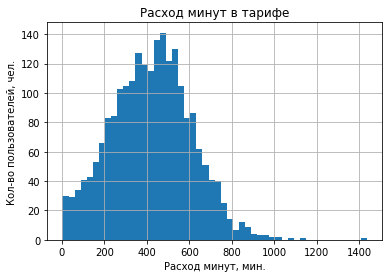

In [29]:
#Смотрим среднее, дисперсию и стандартное отклонение по звонкам среди пользователей Smart и выводим диаграмму.
display(smart['min_sum'].describe())
var_smart_min = np.var(smart['min_sum'], ddof=1)
display(var_smart_min)
smart['min_sum'].hist(bins=50)
# Add labels
plt.title('Расход минут в тарифе')
plt.xlabel('Расход минут, мин.')
plt.ylabel('Кол-во пользователей, чел.')

Среднее - 419,44
Ст. отклонение - 189
Медиана - 423
Дисперсия - 35718,13.
Судя по диаграмме абсолютное большинство лежит в пределах 600 минут, это значит, что большинство клиентов укладываются в лимит 500 минут или незначительно его превышают. Среднее и медиана подтверждают эту теорию.

count    2221.000000
mean       33.392166
std        28.270233
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: sms_num, dtype: float64

799.2060467040656

Text(0, 0.5, 'Кол-во пользователей, чел.')

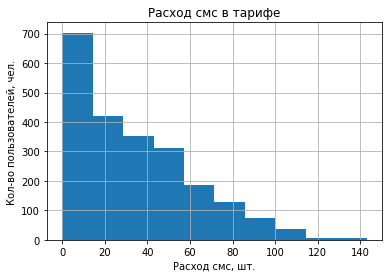

In [30]:
#Смотрим среднее, дисперсию и стандартное отклонение по сообщениям среди пользователей Smart и выводим диаграмму.
display(smart['sms_num'].describe())
var_smart_sms = np.var(smart['sms_num'], ddof=1)
display(var_smart_sms)
smart['sms_num'].hist(bins=10)
# Add labels
plt.title('Расход смс в тарифе')
plt.xlabel('Расход смс, шт.')
plt.ylabel('Кол-во пользователей, чел.')

Среднее - 33,4
Ст. отклонение - 28,27
Медиана - 28
Дисперсия - 799,20.
Лимит 50 сообщений, после 20 сообщений на диаграмме идет плавное снижение. В большинстве своем значения находятся в интервале до 60 сообщений, значит у большинства клиентов нет перерасхода по смс. 

count     947.000000
mean     2061.942978
std       360.136116
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4743.000000
Name: tariff_cost, dtype: float64

129698.02211501324

Text(0, 0.5, 'Кол-во пользователей, чел.')

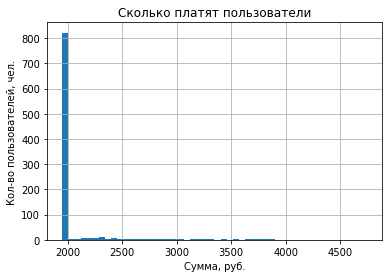

In [31]:
#создаем выборку только пользователей с тарифом Ultra и смотрим по стоимости среднее, дисперсию, стандартное отклонение. Выводим диаграмму.
ultra = group_all.query('tariff == "ultra"')
display(ultra['tariff_cost'].describe())
var_ultra = np.var(ultra['tariff_cost'], ddof=1)
display(var_ultra)
ultra['tariff_cost'].hist(bins=50)
# Add labels
plt.title('Сколько платят пользователи')
plt.xlabel('Сумма, руб.')
plt.ylabel('Кол-во пользователей, чел.')

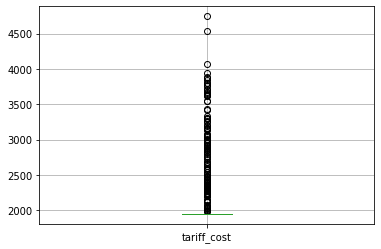

In [32]:
ultra.boxplot(column='tariff_cost')

Среднее - 2062
Ст. отклонение - 360
Медиана - 1950
Дисперсия - 129698,02.
На диаграмме видно, что абсолютное большинство находится на отметке 1950 руб., что означает, пользователи тарифа ультра почти не превышают лимит.

count    947.000000
mean      19.032883
std        9.899449
min        0.000000
25%       11.360840
50%       18.881836
75%       26.237305
max       48.622070
Name: gb_used, dtype: float64

97.99909293729371

Text(0, 0.5, 'Кол-во пользователей, чел.')

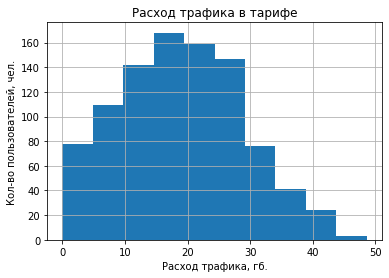

In [33]:
#Смотрим среднее, дисперсию и стандартное отклонение по использованному интернету среди пользователей Ultra и выводим диаграмму.
display(ultra['gb_used'].describe())
var_ultra_gb = np.var(ultra['gb_used'], ddof=1)
display(var_ultra_gb)
ultra['gb_used'].hist(bins=10)
# Add labels
plt.title('Расход трафика в тарифе')
plt.xlabel('Расход трафика, гб.')
plt.ylabel('Кол-во пользователей, чел.')

Среднее - 19
Ст. отклонение - 9,9
Медиана - 19
Дисперсия - 98.
На диаграмме видно, что абсолютное большинство лежит в пределах 30 гб, примерно после 26 значения резко падают, что означает, пользователи тарифа ультра почти не превышают лимит интернета.

count     947.000000
mean      547.755016
std       305.513385
min         1.000000
25%       311.000000
50%       529.000000
75%       758.000000
max      1673.000000
Name: min_sum, dtype: float64

93338.42829141095

Text(0, 0.5, 'Кол-во пользователей, чел.')

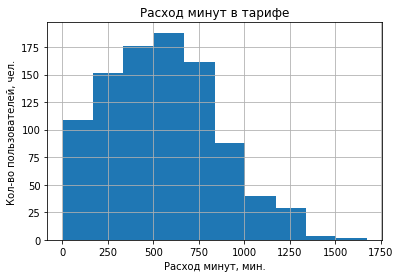

In [34]:
#Смотрим среднее, дисперсию и стандартное отклонение по звонкам среди пользователей Ultra и выводим диаграмму.
display(ultra['min_sum'].describe())
var_ultra_min = np.var(ultra['min_sum'], ddof=1)
display(var_ultra_min)
ultra['min_sum'].hist(bins=10)
plt.title('Расход минут в тарифе')
plt.xlabel('Расход минут, мин.')
plt.ylabel('Кол-во пользователей, чел.')

Среднее - 547
Ст. отклонение - 306
Медиана - 529
Дисперсия - 93338,43
Максимальное значение - 1673 минуты, при лимите в 3000. Соответственно все пользователи укладываются в лимит минут. Пиковое значение - 500-600 минут в месяц. 

count    947.000000
mean      48.759240
std       46.601785
min        0.000000
25%        5.000000
50%       39.000000
75%       78.500000
max      224.000000
Name: sms_num, dtype: float64

2171.7263283853986

Text(0, 0.5, 'Кол-во пользователей, чел.')

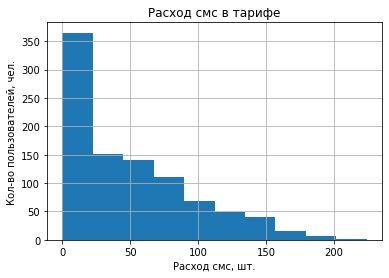

In [35]:
#Смотрим среднее, дисперсию и стандартное отклонение по сообщениям среди пользователей Ultra и выводим диаграмму.
display(ultra['sms_num'].describe())
var_ultra_sms = np.var(ultra['sms_num'], ddof=1)
display(var_ultra_sms)
ultra['sms_num'].hist(bins=10)
# Add labels
plt.title('Расход смс в тарифе')
plt.xlabel('Расход смс, шт.')
plt.ylabel('Кол-во пользователей, чел.')

Среднее - 49
Ст. отклонение - 47
Медиана - 39
Дисперсия - 2171,72
На диаграмме видно, что абсолютное большинство отправляет не больше 100 сообщений в месяц. К лимиту в 1000 никто даже не приближается. 

### Вывод <a name="conc3"></a>

В предыдущих выводах, взглянув на таблицу я заметила, что перерасходов по тарифу смарт больше. Здесь гипотеза подтвердилась, чаще всего люди выходят за рамки лимита в тарифе смарт. 
И среднее и медиана выходят за рамки установленной оплаты тарифного плана Смарт - 550 руб. Это значит, что пользователям не хватает установленных лимитов связи в тарифе. В то время, как в тарифе Ультра нормальным значением является базовая стоимость тарифа - 1950 руб. Кроме того, в тарифе Ультра люди очень далеки от лимитов по минутам и сообщениям, а в Смарт основная доля перерасходов и больших переплат приходится на интернет. 
Соответственно, можно сделать вывод, что оба этих тарифа не очень выгодны для клиентов, т.к. те, кто хочет сэкономить, берут дешевый тариф, т.к. даже с превышениями лимитов это дешевле, чем Ультра, а клиенты тарифа Ультра переплачивают примерно за 1000 лишних минут и около 800 лишних смс. 
Возможно новый тариф с увеличенным лимитом на интернет и уменьшенным лимитом на смс и звонки произвел бы фурор. 

### Шаг 4. Проверьте гипотезы <a name="forth"></a>

средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;
Пороговое значение alpha задайте самостоятельно.
Поясните:
как вы формулировали нулевую и альтернативную гипотезы;
какой критерий использовали для проверки гипотез и почему.

##### Первая нулевая гипотеза: средняя выручка пользователей тарифов Ультра и Смарт равны
##### Вторая нулевая гипотеза: средняя выручка пользователей из Москвы равна региональной. 
##### Нулевая гипотеза всегда формируется со знаком равенства. Альтернативная гипотеза показывает нам, что все варианты выше не равны. 

In [36]:
#создаем группировку по регионам
msk_group = group_all.query('city == "Москва"')
reg_group = group_all.query('city != "Москва"')
#смотрим разницу дисперсий по городам
var_msk = np.var(msk_group['tariff_cost'], ddof=1)
var_reg = np.var(reg_group['tariff_cost'], ddof=1)
display((var_reg - var_msk) / var_reg)
display(var_reg)
display(var_msk)

0.13734916787251852

635043.5474245835

547820.8446230047

In [37]:
#смотрим разницу дисперсий по тарифам
display((var_smart - var_ultra) / var_smart)
display(var_smart)
display(var_ultra)

0.7914474506683212

621896.1241693741

129698.02211501324

In [38]:
#Проверка гипотезы, что средняя выручка пользователей Смарт и Ультра не различается (равна):
#т.к. разница дисперсий более 10%, ставим equal_var=False
alpha = .05
results=st.ttest_ind(smart['tariff_cost'],ultra['tariff_cost'],equal_var=False)

print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
    
display(smart['tariff_cost'].mean())
ultra['tariff_cost'].mean()

p-значение:  2.2206799235918344e-289
Отвергаем нулевую гипотезу


1234.473210265646

2061.9429778247095

Гипотеза подтвердилась. С высокой долей вероятности выручка с тарифов Смарт и Ультра различается.

In [39]:
#Проверка гипотезы, что средняя выручка пользователей из Москвы и регионов не различается (равна):
#т.к. разница дисперсий более 10%, ставим equal_var=False

results=st.ttest_ind(msk_group['tariff_cost'],reg_group['tariff_cost'],equal_var=False)

print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

display(msk_group['tariff_cost'].mean())
reg_group['tariff_cost'].mean()

p-значение:  0.3658457385677769
Не получилось отвергнуть нулевую гипотезу


1506.5590163934426

1475.928068803753

Гипотеза не подтвердилась. Средние расходы пользователей из Москвы с высокой долей вероятности не отличаются.

### Шаг 5. Напишите общий вывод <a name="conc"></a>

Большая доля перерасходов по тарифу приходится на пользователей тарифа Смарт. 
Пользователи тарифа Ультра никогда не используют полностью лимиты на мобильную связь и сообщения. 
Пользователи Москвы и пользователи регионов в среднем тратят одинаковые суммы на связь. 
Тариф Ультра является самым доходным тарифом в линейке из-за высокой абонентской платы. 
По тарифу Смарт у клиентов почти всегда есть перерасход (среднее и медиана выходят за рамки установленной оплаты тарифного плана Смарт - 550 руб). Пользователям не хватает установленных лимитов связи в тарифе. 
В тарифе Ультра 1950 - нормальное значение для оплаты, лимит почти никто не превышает. 
В тарифе Ультра люди очень далеки от лимитов по минутам и сообщениям, а в Смарт основная доля перерасходов и больших переплат приходится на интернет. 

Соответственно, можно сделать вывод, что оба этих тарифа не очень выгодны для клиентов, т.к. те, кто хочет сэкономить, берут дешевый тариф, т.к. даже с превышениями лимитов это дешевле, чем Ультра, а клиенты тарифа Ультра переплачивают примерно за 1000 лишних минут и около 800 лишних смс. 

Возможно новый тариф с увеличенным лимитом на интернет и уменьшенным лимитом на смс и звонки произвел бы фурор. 

### Описание данных
Таблица users (информация о пользователях):
user_id — уникальный идентификатор пользователя
first_name — имя пользователя
last_name — фамилия пользователя
age — возраст пользователя (годы)
reg_date — дата подключения тарифа (день, месяц, год)
churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
city — город проживания пользователя
tariff — название тарифного плана

Таблица calls (информация о звонках):
id — уникальный номер звонка
call_date — дата звонка
duration — длительность звонка в минутах
user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):
id — уникальный номер сообщения
message_date — дата сообщения
user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):
id — уникальный номер сессии
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
session_date — дата интернет-сессии
user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):
tariff_name — название тарифа
rub_monthly_fee — ежемесячная абонентская плата в рублях
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
messages_included — количество сообщений в месяц, включённых в абонентскую плату
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
rub_per_message — стоимость отправки сообщения сверх тарифного пакета
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Примечание. Если объединение таблиц методом merge приводит к ошибке dead kernell, примените метод join — это облегчит нагрузку на Jupyter Notebook.